# Training a neural network on the UrbanSound8K dataset

This post will detail the steps and code used to train a convolutional neural network (Convnet) on the UrbanSound8K dataset.  The aim of this post is to replicate a major part of the work shown in the paper by Salamon et Bello (https://arxiv.org/abs/1608.04363). In their paper, they discuss the technique they used to achieve classification of 10 categories of urban sounds.  They use a a deep convolutional neural network for the classification, and show how data-augmentation can be used with sound files to improve classification accuracy.   The Urbansound8K dataset is open-source and available at https://serv.cusp.nyu.edu/projects/urbansounddataset/urbansound8k.html.

This code is all written using python 2.7, since at the time the code was written most machine-learning libraries were not compatible with python 3.5. A bunch of sound processing libraries were used and need to be installed by anyone trying to replicate this work. Mainly, you need numpy, essentia, librosa, muda, jams, h5py, Keras and all of their dependencies. All libraries used in this code are open-source libraries with available documentation. Keras was used for coding the ConvNet, using tensorflow as the backend. All dependencies needed for tensorflow are needed as well. This entire post was done using ubuntu 16.06, and a dedicated GPU was used for training the network (NVIDIA GTX 980).  The code is written using Jupyter notebook and is meant to be run sequentially. 

The weights and the network structure are also be available as a standalone code separately if you only wish to use those, in which case only Keras and its dependencies are required.

Disclaimer : the paper is not my work and I had no involvement with it. However all of this code is my original work and my interpretation of Salamon et Bello's intent in their paper. Anyone is free to use this work. I do not claim that this is the best method to go about it, but this is the method that worked for me.

Please feel free to contact me should you have any questions regarding this work at jerpint [at] gmail [dot] com.

# Getting Started

Let's start by defining useful imports and paths where the urbansound8k dataset is stored, and where results will be saved (in my case, in a dropbox folder)

In [1]:
audio_source = '/home/jerpint/Desktop/Audiostuff/UrbanSound8K/audio/'

dropbox_path = '/home/jerpint/Dropbox/urbansound/'

from __future__ import division # one of the drawbacks from using python 2.7
from __future__ import print_function
import matplotlib
import sys, os
import csv
import essentia.standard
import numpy as np
import muda
import jams
import librosa
import random
from pylab import plot, show, figure, imshow
from essentia.standard import *
from math import pi, sin, log, exp
from matplotlib import pyplot as plt
import time
import h5py
%matplotlib inline

#my own personal preference for plots
plt.rc('axes',edgecolor='orange')
plt.rc('xtick',color='white')
plt.rc('ytick',color='white')



Now we load the metadata (filenames, labels, paths, etc.) provided with the Urbansound8K dataset

In [2]:
with open('/home/jerpint/Desktop/Audiostuff/UrbanSound8K/metadata/UrbanSound8K.csv', 'rb') as data:
        reader = csv.reader(data)
        metadata = list(reader)
        
        


# Mel spectrograms 

Salamon et al. (and a lot of other research papers looking at sound features) use Mel-spectrograms. At it's core, a Mel-spectrogram is a weighted type of fourrier transform which puts more emphasis on frequencies important to the human-ear. More information on Mel-spectrograms can be found here : https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

Let's define a function which returns the Mel spectrogram of a sound using 128 bins. Hanning windows are used, and the window size is of 23 ms

In [3]:
def mel128_full(audio_signal,Fs = 44100):  # MEL SPECTROGRAM, 128 bins over entire clip
    
    spectrum = Spectrum()
    w = Windowing(type = 'hann')
    

    length = int(round(0.02321995464*Fs)) # number of samples (1024) corresponding to a window size of 23 ms
    melbands = []
    mel = MelBands(highFrequencyBound = Fs/2,numberBands = 128, log = True,normalize = 'unit_max',type = 'magnitude',sampleRate = Fs )

    for frame in FrameGenerator(audio_signal, frameSize = length, hopSize = length,startFromZero=True,validFrameThresholdRatio=1):
        
        frame = np.concatenate((frame,np.zeros((1024))))
        frame = frame.astype('float32')

#         spec_zeropad = np.concatenate(((spectrum(w(frame))),np.zeros(1)))
#         spec_zeropad = spec_zeropad.astype('float32')
#        mel_specs = mel(spec_zeropad)
        
        mel_specs = mel(spectrum(w(frame)))
        melbands.append(mel_specs)

    melbands= essentia.array(melbands).T
    return melbands


Let's make sure our spectrogram works properly. We can start by testing it out on a sine-sweep and seeing the representation that we get.

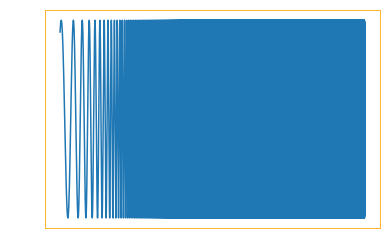

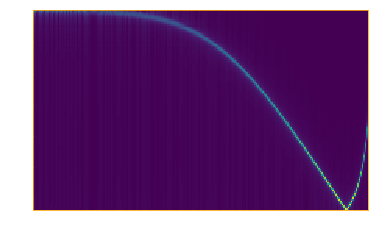

In [4]:
def sweep(f_start, f_end, interval, n_steps):  # function to generate a sweep sine signal
    ret = np.zeros((n_steps,1))
    b = log(f_end/f_start) / interval
    a = 2 * pi * f_start / b
    for i in range(n_steps):
        delta = i / float(n_steps)
        t = interval * delta
        g_t = a * exp(b * t)
        ret[i] =   1* sin(g_t)
    return ret

audio_sweep = sweep(1, 10000, 20, 5*44100)
audio_sweep = np.squeeze(audio_sweep)
audio_sweep  = audio_sweep.astype('float32')
plt.plot(audio_sweep) #sweep signal for debugging
plt.figure()
plt.imshow(mel128_full(audio_sweep))

We can see, on top, the time domain sweep signal, and on the bottom, the mel spectrogram representation. We can see the frequencies increasing, and even aliasing.

Now let's look at what the Mel spectrograms might look like for different sound categories : 

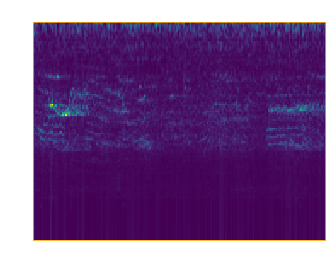

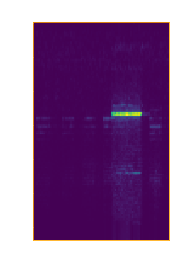

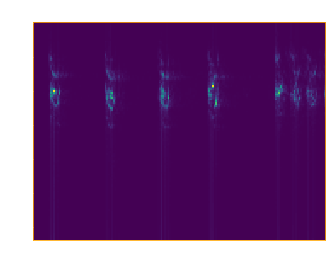

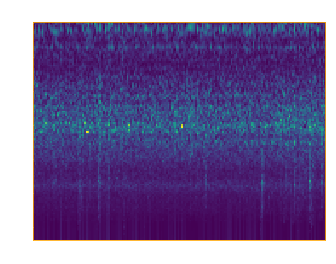

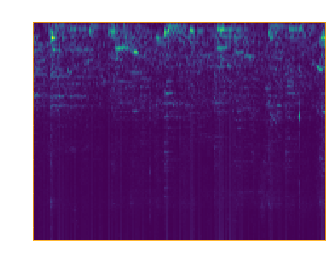

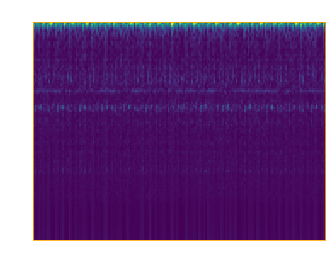

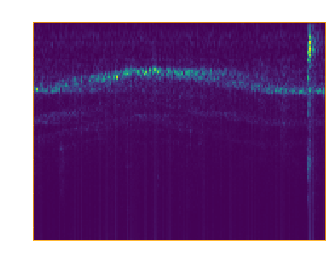

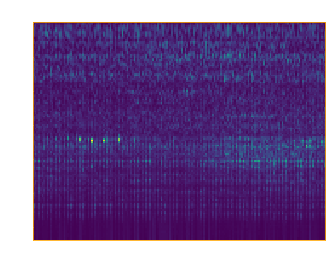

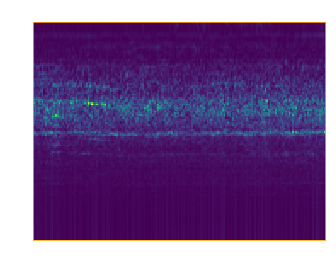

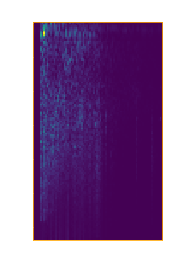

In [5]:
def show_mel(ii): #show mel for iith sample
    
    filename = audio_source + 'fold' +metadata[ii][5] + '/' + metadata[ii][0]
    y,sr = librosa.load(filename,sr=44100,mono=True)

    plt.figure()
    plt.imshow(mel128_full(y,Fs=sr))
    plt.title(metadata[ii][7],color='white')
#     print(metadata[ii][7])
#     print(filename)
for ii in [5,14,22,25,99,148,116,176,209,1383]:
    show_mel(ii)

# Data augmentation

One of the major contributions by Salamon et al. was the use of sound augmentation using pitch shift, adding background noises, time shifting, pitch shifting, and dynamic range compression. We define a function to do each of these deformations.  The muda library was extremely useful in this case.

In [6]:
# define all pre processing steps
def pitch_shift(j_orig):
    
    j_aug = []
    semitones = [-3.5,-2.5,-2,-1,1,2,2.5,3.5]
    for sem in semitones:
        pitch = muda.deformers.PitchShift(n_semitones=sem)
        dropbox_path = '/home/jerpint/Dropbox/urbansound/'

        for i, jam_out in enumerate(pitch.transform(j_orig)):

            audio_test = jam_out.sandbox.muda._audio['y'];
            audio_test = audio_test.astype('float32');
            j_aug.append( mel128_full(audio_test));

    return j_aug




def bg_noise(j_orig):
    j_aug = []
    
    file_bg1  = dropbox_path + 'bg/150993__saphe__street-scene-1.flac'
    file_bg2 = dropbox_path + 'bg/173955__saphe__street-scene-3.flac'
    file_bg3 = dropbox_path + 'bg/207208__jormarp__high-street-of-gandia-valencia-spain.wav'
    file_bg4 = dropbox_path + 'bg/268903__yonts__city-park-tel-aviv-israel.wav'


    bg = muda.deformers.BackgroundNoise(n_samples=1, files=[file_bg1,file_bg2,file_bg3,file_bg4], weight_min=0.1, weight_max=0.5)
    #muda.core.save(dropbox_path+'orig.wav',audio_source+'orig.jams',j_orig)


    for i, jam_out in enumerate(bg.transform(j_orig)):

        

        audio_test = jam_out.sandbox.muda._audio['y']
        audio_test = audio_test.astype('float32')
        j_aug.append( mel128_full(audio_test))

    return j_aug

def drc_aug(j_orig):
    drc = muda.deformers.DynamicRangeCompression(preset=['radio','film standard','film light','speech'])
    j_aug = []



    for i, jam_out in enumerate(drc.transform(j_orig)):

        audio_test = jam_out.sandbox.muda._audio['y']
        audio_test = audio_test.astype('float32')
        j_aug.append(mel128_full(audio_test))
    return j_aug

def time_stretch(j_orig):
    rates = [0.81,0.93,1.07,1.23]
    j_aug = []
    for rate in rates:
        stretch = muda.deformers.TimeStretch(rate =rate)


        for i, jam_out in enumerate(stretch.transform(j_orig)):


            audio_test = jam_out.sandbox.muda._audio['y'];
            audio_test = audio_test.astype('float32');
            j_aug.append(mel128_full(audio_test));
    return j_aug


def no_deform(j_orig,show=False):
    j_aug = []
    audio_test = j_orig.sandbox.muda._audio['y']
    audio_test = audio_test.astype('float32')

    j_aug.append(mel128_full(audio_test))
    if(show==True):
        plt.figure()
        plt.imshow(mel128_full(audio_test))

    return j_aug


Now let's apply all the transformations to all of the sounds in the dataset. For each individual sound file, we apply each possibile transformation and compute its mel spectrogram. We save each spectrogram as an individual np file. This step can take a few hours, and will yield approximately 12 gb of data. 

In [8]:




import time
start_time = time.time()

for  ii in range(1,len(metadata)): # shuffle through all examples in the .csv file, approx 8700 of them
    if (ii/100 == round(ii/100)): # have a counter to keep track of progress
        print('iteration',ii)
        print('time since start')
        print("--- %s seconds ---" % (time.time() - start_time))

        
        

    filename_no_ext = metadata[ii][0][:-4]
    filename_np = '/home/jerpint/Desktop/Audiostuff/aug_new/fold' +metadata[ii][5] + '/' + filename_no_ext
    filename = audio_source + 'fold' +metadata[ii][5] + '/' + metadata[ii][0]
    filename_jams = filename.replace('.wav','.jams')
    
    
    y,sr = librosa.load(filename,sr=44100,mono=True) # load the sound using librosa, insuring sample rate of 44100
    #plt.plot(y)
    
    # create the jams file
    jam = jams.JAMS()
    jam.file_metadata.duration = len(y)/sr
    jam.file_metadata.title = '/fold' +metadata[ii][5] + '/' + metadata[ii][0]
    jam.file_metadata.artist = metadata[ii][7]
    jam.dumps()
    #filename_jams = filename.replace('.wav','.jams')
    #jam.save(filename_jams)
    
    j_orig = muda.jam_pack(jam, _audio=dict(y=y, sr=sr))
    # load the jams file
    
    
    mel_orig = no_deform(j_orig) # do no deformation (keep a copy of original)
    filename_orig = filename_np+'_orig_'+str(0)+'.npy' #save all deformations
    np.save(filename_orig,mel_orig[0])
    
    
    mel_aug_time = time_stretch(j_orig) #time stretch
    for jj in range(len(mel_aug_time)): # number of time stretches
        filename_orig = filename_np+'_time_'+str(jj)+'.npy' #save all deformations
        np.save(filename_orig,mel_aug_time[jj])

    
    mel_aug_pitch = pitch_shift(j_orig) #pitch shift
    for jj in range(len(mel_aug_pitch)):
        filename_orig = filename_np+'_pitch_'+str(jj)+'.npy' #save all deformations
        np.save(filename_orig,mel_aug_pitch[jj])

    mel_aug_bg = bg_noise(j_orig) # background noise
    for jj in range(len(mel_aug_bg)):
        filename_orig = filename_np+'_bg_'+str(jj)+'.npy' #save all deformations
        np.save(filename_orig,mel_aug_bg[jj])
    
    
    mel_aug_drc = drc_aug(j_orig) # dynamic range compression
    for jj in range(len(mel_aug_drc)):
        filename_orig = filename_np+'_drc_'+str(jj)+'.npy' #save all deformations
        np.save(filename_orig,mel_aug_drc[jj])
    
    
    
    
    
stop_time = time.time()
time_taken = start_time - stop_time
print("--- %s seconds ---" % (time.time() - start_time)) # time counter to see how long this step takes


iteration 100
time since start
--- 482.713695049 seconds ---
iteration 200
time since start
--- 960.819436073 seconds ---
iteration 300
time since start
--- 1433.8909142 seconds ---
iteration 400
time since start
--- 1893.36591101 seconds ---
iteration 500
time since start
--- 2355.52870512 seconds ---
iteration 600
time since start
--- 2824.50602913 seconds ---
iteration 700
time since start
--- 3324.22076511 seconds ---
iteration 800
time since start
--- 3809.73672819 seconds ---
iteration 900
time since start
--- 4270.10609603 seconds ---
iteration 1000
time since start
--- 4703.88646913 seconds ---
iteration 1100
time since start
--- 5166.78309608 seconds ---
iteration 1200
time since start
--- 5629.688236 seconds ---
iteration 1300
time since start
--- 6121.13446617 seconds ---
iteration 1400
time since start
--- 6612.57023406 seconds ---
iteration 1500
time since start
--- 6981.40977001 seconds ---
iteration 1600
time since start
--- 7450.8983252 seconds ---
iteration 1700
time s

/usr/local/lib/python2.7/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


iteration 2700
time since start
--- 12428.862689 seconds ---
iteration 2800
time since start
--- 12919.4329081 seconds ---
iteration 2900
time since start
--- 13392.7536111 seconds ---
iteration 3000
time since start
--- 13815.42643 seconds ---
iteration 3100
time since start
--- 14233.3882201 seconds ---
iteration 3200
time since start
--- 14662.631741 seconds ---
iteration 3300
time since start
--- 15129.9856071 seconds ---
iteration 3400
time since start
--- 15593.697119 seconds ---
iteration 3500
time since start
--- 16054.5564001 seconds ---
iteration 3600
time since start
--- 16544.6034932 seconds ---
iteration 3700
time since start
--- 17030.2355862 seconds ---
iteration 3800
time since start
--- 17511.3246281 seconds ---
iteration 3900
time since start
--- 18027.245265 seconds ---
iteration 4000
time since start
--- 18530.7338831 seconds ---
iteration 4100
time since start
--- 19033.0180922 seconds ---
iteration 4200
time since start
--- 19483.9101522 seconds ---
iteration 4300

Next we define functions which will load a mel spectrogram, determine if it is longer than 3 seconds and sample 1/8th of all possible positions at random. We are following the same procedure as followed by Salamon et al. The 3 seconds criteria is important if we want to ensure that all mel-spectrograms are 128x128 for training, since we need a constant input size during training. Not all files are 3 seconds long. It is not made explicit in Salamon's paper what was done in those cases. It is possible to zero-pad them, but this could lead to some bias during classification. We chose to ignore them, feel free to pad with zeros otherwise in the else statement where it prints 'File is not long enough'

In [9]:



# load a specific deformation to memomry

def load_def(filename_np,deformation,jj): # 'deformation' can be one of these : [bg,pitch,time,orig,drc] 
    filename_path = filename_np+'_'+deformation+'_'+str(jj)+'.npy' #save all deformations
    sound = np.load(filename_path)
    return sound

# from a single deformation, extract 1/8th of it at random for training/testing
def file_to_X_tmp(def_tmp):
    if(def_tmp.shape[1]>128): # check that clip is longer than 3s
        dim = def_tmp.shape[1]-128 # dim is the number of potential postions to extract from
    

        ones= int(np.floor(dim/8))
        zeros = dim-ones
        idx = np.concatenate((np.zeros((zeros,1)),np.ones((ones,1))))
        idx = np.ndarray.tolist(idx)
        random.shuffle(idx)
        idx = np.asarray(idx)
        X_tmp = np.zeros((ones,128,128))

        locs,wtvr = (np.where(idx==True))

        for kk,loc in enumerate ((locs)):

            X_tmp[kk,:,:] = def_tmp[:,loc:loc+128]
        return X_tmp
    else:
        print('File not long enough')
        return []

# combine all deformations for a single track in a variable X, assign label y
def generate_X(filename_np,meta):
    
    X = np.zeros((1,128,128)) # instantiate
    meta_info = []
    meta_info.append([])
    info_tmp = list(meta) #copy the metadata
    
    for kk in range(0,1):
        time_tmp = load_def(filename_np,'orig',kk)
        X_tmp = file_to_X_tmp(time_tmp)

        X = np.concatenate((X, X_tmp))
        info_tmp = list(meta)
        deform_info = 'orig_'+str(kk)
        info_tmp.append(deform_info)
        for w in range(len(X_tmp)):
            meta_info[-1].append(info_tmp)        
        
    for kk in range(0,4):
        time_tmp = load_def(filename_np,'time',kk)
        X_tmp = file_to_X_tmp(time_tmp)
        
        # store all deformations in a list
        info_tmp = list(meta)
        deform_info = 'time_'+str(kk)
        info_tmp.append(deform_info)
        for w in range(len(X_tmp)):
            meta_info[-1].append(info_tmp)
        
        X = np.concatenate((X, X_tmp))
        


    for kk in range(0,4):
        time_tmp = load_def(filename_np,'bg',kk)
        X_tmp = file_to_X_tmp(time_tmp)

        X = np.concatenate((X, X_tmp))
        # store all deformations in a list
        info_tmp = list(meta)
        deform_info = 'bg_'+str(kk)
        info_tmp.append(deform_info)
        for w in range(len(X_tmp)):
            meta_info[-1].append(info_tmp)
        


    for kk in range(0,8):
        time_tmp = load_def(filename_np,'pitch',kk)
        X_tmp = file_to_X_tmp(time_tmp)

        X = np.concatenate((X, X_tmp))

        # store all deformations in a list
        info_tmp = list(meta)
        deform_info = 'pitch_'+str(kk)
        info_tmp.append(deform_info)
        for w in range(len(X_tmp)):
            meta_info[-1].append(info_tmp)
        

        
    for kk in range(0,4):
        time_tmp = load_def(filename_np,'drc',kk)
        X_tmp = file_to_X_tmp(time_tmp)
        #print(X.shape)

        X = np.concatenate((X, X_tmp))
    
        info_tmp = list(meta)
        deform_info = 'drc_'+str(kk)
        info_tmp.append(deform_info)
        for w in range(len(X_tmp)):
            meta_info[-1].append(info_tmp)
        


        

    X = np.delete(X,0,axis=0) # delete first instantiation
    #y = np.ones((X.shape[0],1))*int(label)

    return X,meta_info[0]

    

Because we have so much data, we will not be able to store it all in RAM when training. To get around this, we store everything in hdf5 files, one for testing, one for training, and one for validation. We store all metadata info separately. We will call the files in batches using Keras later on.

In [10]:

start_time = time.time()


f_test = h5py.File("/home/jerpint/Desktop/Audiostuff/aug_new/Xtest.h5", "w")
f_train = h5py.File("/home/jerpint/Desktop/Audiostuff/aug_new/Xtrain.h5", "w")
f_valid = h5py.File("/home/jerpint/Desktop/Audiostuff/aug_new/Xvalid.h5", "w")

dset_test = f_test.create_dataset("urbansound", (1e6,128,128), dtype='float32')
dset_train = f_train.create_dataset("urbansound", (1e6,128,128), dtype='float32')
dset_valid = f_valid.create_dataset("urbansound", (1e6,128,128), dtype='float32')

fold_test  = 10 # which fold will be used for test set
fold_valid = 5# which fold wil be used for validation

count_test = 0
count_train = 0
count_val = 0
y_label_test = []
y_label_train = []
y_label_valid = []

meta_info_test = []
meta_info_train = []
meta_info_valid = []

for  ii in range(1,len(metadata)):
    
    filename_no_ext = metadata[ii][0][:-4]
    filename_np = '/home/jerpint/Desktop/Audiostuff/aug_new/fold' +metadata[ii][5] + '/' + filename_no_ext
    
    def_temp = load_def(filename_np,'time',3)
    if(def_temp.shape[1]>128): #checks thath the file size is greater than 3 seconds to sample from
    
        label = metadata[ii][-2] # get the label
        X_tmp,meta_info =  generate_X(filename_np,metadata[ii]) # get the metadata and the data
        
        
        if(int(metadata[ii][5])==fold_test): #sort by fold
        
            meta_info_test.extend(meta_info) # store the meta info at same indices as X


            for kk in range(X_tmp.shape[0]):

                dset_test[count_test] = X_tmp[kk,:,:]
                y_label_test.append(label)
                count_test = count_test +1
        
        elif(int(metadata[ii][5])==fold_valid):
            meta_info_valid.extend(meta_info) # store the meta info at same indices as X


            for kk in range(X_tmp.shape[0]):

                dset_valid[count_val] = X_tmp[kk,:,:]
                y_label_valid.append(label)
                count_val = count_val +1
        else:
        
            meta_info_train.extend(meta_info) # store the meta info at same indices as X


            for kk in range(X_tmp.shape[0]):

                dset_train[count_train] = X_tmp[kk,:,:]
                y_label_train.append(label)
                count_train = count_train +1

    
    
    else:
        print('skipped : ',ii,filename_np)

        
stop_time = time.time()
time_taken = start_time - stop_time
print("--- %s seconds ---" % (time.time() - start_time))
f_test.close()
f_train.close()
f_valid.close()

print('count train',count_train)
print('count valid',count_val)
print('count test',count_test)


# save these variables since they will be useful later on, so that this part of the code does not need to be run again
np.save('count_train',count_train)
np.save('count_val',count_val)
np.save('count_test',count_test)

np.save('meta_info_train',meta_info_train)
np.save('meta_info_test',meta_info_test)
np.save('meta_info_valid',meta_info_valid)

np.save('y_label_test',y_label_test)
np.save('y_label_train',y_label_train)
np.save('y_label_valid',y_label_valid)

skipped :  1 /home/jerpint/Desktop/Audiostuff/aug_new/fold5/100032-3-0-0
skipped :  10 /home/jerpint/Desktop/Audiostuff/aug_new/fold10/100648-1-0-0
skipped :  11 /home/jerpint/Desktop/Audiostuff/aug_new/fold10/100648-1-1-0
skipped :  12 /home/jerpint/Desktop/Audiostuff/aug_new/fold10/100648-1-2-0
skipped :  13 /home/jerpint/Desktop/Audiostuff/aug_new/fold10/100648-1-3-0
skipped :  14 /home/jerpint/Desktop/Audiostuff/aug_new/fold10/100648-1-4-0
skipped :  101 /home/jerpint/Desktop/Audiostuff/aug_new/fold4/102102-3-0-0
skipped :  102 /home/jerpint/Desktop/Audiostuff/aug_new/fold10/102103-3-0-0
skipped :  103 /home/jerpint/Desktop/Audiostuff/aug_new/fold10/102103-3-1-0
skipped :  104 /home/jerpint/Desktop/Audiostuff/aug_new/fold2/102104-3-0-0
skipped :  106 /home/jerpint/Desktop/Audiostuff/aug_new/fold1/102106-3-0-0
skipped :  107 /home/jerpint/Desktop/Audiostuff/aug_new/fold1/102305-6-0-0
skipped :  182 /home/jerpint/Desktop/Audiostuff/aug_new/fold1/103074-7-2-0
skipped :  194 /home/jerp

We now have all of our features and labels created and we are ready to start training our Convolutional Neural Network!

# Convolutional Neural Network

Here we define some batch generators. These are a very handy feature of Keras. They allow us to create mini-batches on the fly. This allows us to call the preprocessed data we have created previously only as we need them. This avoids loading all of the variables up in RAM, which would probably not work will all the data we have generated. This is the reason why we created the hdf5 files previously; all of the data is stored on the hard drive, and the batch_generator will allow us to call on it during training

In [11]:


def batch_generator_train():
    
    from keras.utils import np_utils

    global f_train
    global batch_size
    global count_train
    global meta_info_train
    global nb_classes

    dset_train = f_train['urbansound']
    idx = range(0,count_train)
    np.random.shuffle(idx)
    count=0
    while 1:
        idx_tmp = idx[count*batch_size:(count+1)*batch_size]
        if (count/100 == round(count/100)): # print to see our progress during training
            print('train count',count)
        X_train = np.zeros((batch_size,128,128,1))
        y_train = np.zeros(batch_size)


        for ii,jj in enumerate( idx_tmp ):
            X_train[ii,:,:,0] = dset_train[jj]
            y_train[ii] = meta_info_train[jj][6]


        Y_train = np_utils.to_categorical(y_train, nb_classes)
        yield X_train,Y_train
        count=count+1
        if (count*batch_size>count_train):
            count = 0

def batch_generator_val():
    
    from keras.utils import np_utils

    global f_val
    dset_val = f_val['urbansound']
    global batch_size
    global count_val
    global meta_info_valid
    global nb_classes
    idx = range(0,count_val)
    np.random.shuffle(idx)
    count=0
    while 1:
        if (count/100 == round(count/100)):
            print('valid count',count)

        idx_tmp = idx[count*batch_size:(count+1)*batch_size]
        X_val = np.zeros((batch_size,128,128,1))
        y_val = np.zeros(batch_size)

        for ii,jj in enumerate( idx_tmp ):
            X_val[ii,:,:,0] = dset_val[jj]
            y_val[ii] = meta_info_valid[jj][6]
            
        Y_val = np_utils.to_categorical(y_val, nb_classes)
        yield X_val,Y_val
        count=count+1
        if (count*batch_size>count_val):
            count = 0



def batch_generator_test(meta_info_test,idx):
    f_test = h5py.File("/home/jerpint/Desktop/Audiostuff/aug/Xtest.h5", "r")
    dset_test = f_test['urbansound']
    X_test = np.zeros((len(idx),128,128,1))
    y_test = np.zeros(len(idx))
    y_meta_test_all = []
    for ii,jj in enumerate( idx ):
        X_test[ii,:,:,0] = dset_test[jj]
        y_test[ii] = meta_info_test[jj][6]
        y_meta_test_all.append( meta_info_test[jj])
    f_test.close()
    return X_test,y_test


We are now ready to define our Network structure and set up everything for training. As highlighted in the paper, the network consists of 3 Convolutional layers with pooling and 2 fully connected layers

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras import backend as K

np.random.seed(1337)  # for reproducibility



# these variables we're created prior, load them again in case this is started in a separate session
count_train=np.load('count_train.npy') 
count_val = np.load('count_val.npy')
count_test=np.load('count_test.npy')

meta_info_train= np.load('meta_info_train.npy')
meta_info_test = np.load('meta_info_test.npy')
meta_info_valid = np.load('meta_info_valid.npy')

y_label_test = np.load('y_label_test.npy')
y_label_train = np.load('y_label_train.npy')
y_label_valid = np.load('y_label_valid.npy')

# important definitions
batch_size = 128
nb_classes = 10
nb_epochs = 20

# input image dimensions
img_rows, img_cols = 128, 128
# number of convolutional filters to use
l1_nb_filters = 24
l2_nb_filters = 48
l3_nb_filters = 48

# size of pooling area for max pooling
l1_pool_size = (4, 2)
# convolution kernel size
l1_kernel_size = (5, 5)

l2_pool_size = (4, 2)
# convolution kernel size
l2_kernel_size = (5, 5)

l3_kernel_size = (5, 5)


l4_layer_size = 64

input_shape = (img_rows, img_cols, 1)

# X_train = X_train.astype('float32')



model = Sequential()

#conv1 layer
model.add(Conv2D(filters = l1_nb_filters, kernel_size = l1_kernel_size,
                 padding='valid',input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=l1_pool_size))
model.add(Conv2D(l2_nb_filters, kernel_size = l2_kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=l2_pool_size))
model.add(Dropout(0.5))
model.add(Conv2D(l3_nb_filters, kernel_size = l3_kernel_size))
model.add(Activation('relu'))



model.add(Flatten())
model.add(Dense(l4_layer_size))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
#           verbose=0, validation_data=(X_test, Y_test))
f_train = h5py.File("/home/jerpint/Desktop/Audiostuff/aug_new/Xtrain.h5", "r")
f_val = h5py.File("/home/jerpint/Desktop/Audiostuff/aug_new/Xvalid.h5", "r")

generator_train = batch_generator_train()
generator_val = batch_generator_val()

# callbacks will only save the weight with the highest validation accuracy at every epoch
filepath = 'weights_final_test.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


history = model.fit_generator(generator= generator_train,steps_per_epoch=int(np.floor((count_train)/batch_size)),
                              epochs=nb_epochs,verbose=2,validation_data=generator_val,
                              validation_steps= int(np.floor((count_val)/batch_size)),callbacks = callbacks_list)

idx_test = range(0,count_test)
X_test,y_test = batch_generator_test(meta_info_test,idx_test)

X_test = X_test.astype('float32')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_test = np_utils.to_categorical(y_test, nb_classes)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
f_train.close()
f_val.close()

train countEpoch 1/20
 0
train count 100
train count 200
train count 300
train count 400
train count 500
train count 600
train count 700
train count 800
train count 900
train count 1000
train count 1100
train count 1200
train count 1300
train count 1400
train count 1500
train count 1600
train count 1700
train count 1800
train count 1900
train count 2000
train count 2100
train count 2200
train count 2300
train count 2400
train count 2500
train count 2600
train count 2700
train count 2800
train count 2900
train count 3000
train count 3100
train count 3200
train count 3300
train count 3400
train count 3500
train count 3600
train count 3700
train count 3800
train count 3900
train count 4000
train count 4100
train count 4200
train count 4300
train count 4400
train count 4500
train count 4600
train count 4700
train count 4800
train count 4900
valid count 0
train count 0
valid count 100
valid count 200
valid count 300
valid count 400
valid count 500
valid count 600
6039s - loss: 0.8639 - acc:

KeyboardInterrupt: 

# Results

Let's look at some of the performance metrics of our network. For starters, let's build a confusion matrix on our test set

In [16]:
idx_test = range(0,count_test)
X_test,y_test = batch_generator_test(meta_info_test,idx_test)

X_test = X_test.astype('float32')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_test = np_utils.to_categorical(y_test, nb_classes)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

preds = model.predict(X_test)
conf_matrix = np.zeros((10,10))

for ii in range(0,preds.shape[0]):
    idx_tmp = np.where(preds[ii,:] == max(preds[ii,:]))
    x = int(y_test[ii])
    y = int(idx_tmp[0])
    conf_matrix[x,y] = conf_matrix[x,y]+1

    
import pandas

pandas.DataFrame(conf_matrix)

75584 test samples
Test score: 1.41537265449
Test accuracy: 0.733885478408


,0,1,2,3,4,5,6,7,8,9
0,7036.0,27.0,825.0,19.0,209.0,1678.0,5.0,216.0,168.0,517.0
1,23.0,200.0,51.0,0.0,0.0,44.0,0.0,0.0,0.0,1394.0
2,87.0,166.0,8376.0,284.0,467.0,30.0,0.0,2.0,334.0,740.0
3,29.0,10.0,1227.0,5245.0,181.0,21.0,4.0,20.0,143.0,462.0
4,576.0,10.0,161.0,72.0,6790.0,106.0,0.0,188.0,435.0,650.0
5,671.0,1.0,527.0,28.0,38.0,7193.0,0.0,187.0,338.0,540.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,28.0,0.0,1.0,244.0,4.0,7616.0,0.0,0.0
8,581.0,13.0,1917.0,1039.0,119.0,79.0,0.0,0.0,4076.0,415.0
9,88.0,87.0,946.0,13.0,76.0,66.0,1.0,22.0,463.0,8938.0


Our network isn't perfect, but it definitely learned something! There is lots of hyper-parameter search to be done to improve on network performance. There are other techniques that can definitely be used to improve performance, not to mention using other datasets to enhance the data

# Deploying the network

Let's see how to deploy the network in the wild / try to classify sounds from other source. We first redefine the network here so that it can be loaded from scratch and uses the best weights that we found :

In [14]:
from keras.models import load_model
import keras
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras import backend as K

batch_size = 128
nb_classes = 10
nb_epoch = 12

# input image dimensions
img_rows, img_cols = 128, 128
# number of convolutional filters to use
l1_nb_filters = 24
l2_nb_filters = 48
l3_nb_filters = 48

# size of pooling area for max pooling
l1_pool_size = (4, 2)
# convolution kernel size
l1_kernel_size = (5, 5)

l2_pool_size = (4, 2)
# convolution kernel size
l2_kernel_size = (5, 5)

l3_kernel_size = (5, 5)


l4_layer_size = 64

input_shape = (img_rows, img_cols, 1)

# X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
# X_train /= 255
# X_test /= 255
# print('X_train shape:', X_train.shape)
# print(X_train.shape[0], 'train samples')

# convert class vectors to binary class matrices
# Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

#conv1 layer
model.add(Conv2D(filters = l1_nb_filters, kernel_size = l1_kernel_size,
                 padding='valid',input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=l1_pool_size))
model.add(Conv2D(l2_nb_filters, kernel_size = l2_kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=l2_pool_size))
model.add(Dropout(0.5))
model.add(Conv2D(l3_nb_filters, kernel_size = l3_kernel_size))
model.add(Activation('relu'))



model.add(Flatten())
model.add(Dense(l4_layer_size))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])


model = load_model('/home/jerpint/Dropbox/urbansound/weights_final_test.hdf5')

Specify the file you want to test here :

In [74]:
#define labels
labels = [ 'air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']



#filename = '/home/jerpint/Dropbox/urbansound/sound samples/115239__xserra__warsaw-street-musicians-1 (1).wav'
filename = '/home/jerpint/Dropbox/urbansound/phone_recordings/categories/air_conditioner/air_conditioner.m4a'
y,sr = librosa.load(filename,sr=44100,mono=True)
# load the file

# calculate its mel bands
X = mel128_full(y)

# reshape it such that it is compatible with our convnet
X_test = np.zeros((X.shape[1]-128,X.shape[0],X.shape[0]))

for ii in range(X_test.shape[0]):
    X_test[ii,:,:] = X[:,ii:ii+128]
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2],1))


# Make our prediction
y_pred = model.predict(X_test)

label_pred = np.zeros((10,1))


# store every prediction made by the network for each frame, output the majority prediction

for ii in range(0,X_test.shape[0]):
    label_tmp = np.where(y_pred[ii,:]==np.max(y_pred[ii,:]))
    #print(np.where(y_pred[ii,:]==np.max(y_pred[ii,:])))
    label_pred[label_tmp[0]]+=1
prediction_final = np.where(label_pred==np.max(label_pred))[0]
print('1st predicted class : ' , labels[int(prediction_final)])
prediction_second = np.where(label_pred==np.sort(np.resize(label_pred,label_pred.shape[0]))[-2])[0][0]
print('2nd predicted class : ',labels[int(prediction_second)])
print('')
print('prediction probability per class: ')
print('')
for jj in range(len(labels)):
    print(labels[jj], (label_pred[jj]/np.sum(label_pred))*100,' % ')



1st predicted class :  air_conditioner
2nd predicted class :  car_horn

prediction probability per class: 

air_conditioner [ 100.]  % 
car_horn [ 0.]  % 
children_playing [ 0.]  % 
dog_bark [ 0.]  % 
drilling [ 0.]  % 
engine_idling [ 0.]  % 
gun_shot [ 0.]  % 
jackhammer [ 0.]  % 
siren [ 0.]  % 
street_music [ 0.]  % 


In [60]:
label[9]

IndexError: string index out of range

In [48]:
labels[0]

'air_conditioner'

In [41]:
np.sort(np.resize(label_pred,label_pred.shape[0]))[-2]

460.0